## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

10599925
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
10        1     1            7  3869200167        2785         4   
12        1     1            6  3869200167        2792        18   
15        1     1          139  3869200167        2797         0   
16        0     1            8  3869200167        2787        14   
18        1     1            5  3869200167        2795         4   
20        0     1           10  3869200167        2789        14   
43        1     1            1  3869200168           7        18   
45        0     1            1  3869200168          13        18   
47        1     1            2  3869200168          17        26   
54        0     1           61  3869200168         260        16   
55        0     1           59  3869200168         270        21   
56        1     1          139  3869200168         272         0   
57        1     1           62  3869200168         263        20   
58        0     1          127  3869200

/opt/ubuntu-16.04/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/ubuntu-16.04/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


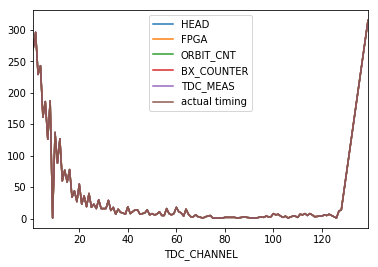

In [70]:
import pandas as pd
import numpy as np
file_name="data/data_000637.txt"
data=pd.read_csv(file_name)
data2 = data[0:12000]
#data2.loc[:,'x'] = pd.Series(data2['ORBIT_CNT']/data2['BX_COUNTER'])
x = data2['BX_COUNTER'].max()

maxOrbit = data2['ORBIT_CNT'].max()
minOrbit = data2['ORBIT_CNT'].min()
orbit = maxOrbit - minOrbit
lasted = orbit * x * 25

data2['actual timing'] = pd.Series((data2['ORBIT_CNT']*x) + (data2['BX_COUNTER']*25*10**(-9))+data2['TDC_MEAS'])
print(lasted)

data2['HEAD'] = np.random.choice([0, 1],size=len(data2))
data3 = data2[data2['HEAD'] > 0]
data4 = data2[data2['TDC_CHANNEL'] >= 139]
uvalues = data4.ORBIT_CNT.unique()
tdcValues = data2.TDC_CHANNEL.unique()

zeroFpga = data2[data2['FPGA'] > 0]
zeroplot = zeroFpga.groupby('TDC_CHANNEL').count()
print(zeroFpga)
print(len(uvalues))

%matplotlib inline
zeroplot.plot()
